In [1]:
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
import cv2

# Load the images directories
path = r"/Users/san5h0llow/Data_Science/Face_recognition/Data_Set"
image_paths = list(paths.list_images(path))

In [2]:
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    images.append(image)
    labels.append(label)

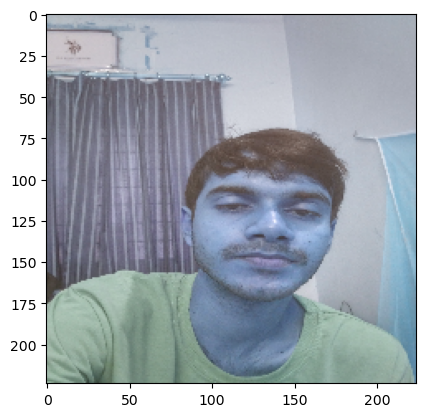

In [3]:
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])

In [4]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import numpy as np

images = np.array(images) / 255.0
labels = np.array(labels)

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

2024-03-19 21:03:44.515837: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from sklearn.model_selection import train_test_split

(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)

In [6]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(2907, 224, 224, 3)
(2907, 2)
(324, 224, 224, 3)
(324, 2)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

In [8]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input

base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
batch_size = 40
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 10

In [13]:
history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size), steps_per_epoch= train_steps, validation_data = (test_X, test_Y), validation_steps= validation_steps, epochs= epochs)

/var/folders/29/qgdtjbz504l5y0fqzxvwjwy00000gn/T/ipykernel_9057/504464780.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size), steps_per_epoch= train_steps, validation_data = (test_X, test_Y), validation_steps= validation_steps, epochs= epochs)


Epoch 1/10
72/72 [==============================] - 1098s 15s/step - loss: 0.3986 - accuracy: 0.8493 - val_loss: 0.1748 - val_accuracy: 0.9722
Epoch 2/10
72/72 [==============================] - 1067s 15s/step - loss: 0.1422 - accuracy: 0.9630 - val_loss: 0.0721 - val_accuracy: 0.9907
Epoch 3/10
72/72 [==============================] - 1065s 15s/step - loss: 0.0777 - accuracy: 0.9836 - val_loss: 0.0383 - val_accuracy: 0.9969
Epoch 4/10
72/72 [==============================] - 1064s 15s/step - loss: 0.0566 - accuracy: 0.9885 - val_loss: 0.0257 - val_accuracy: 0.9969
Epoch 5/10
72/72 [==============================] - 1071s 15s/step - loss: 0.0391 - accuracy: 0.9916 - val_loss: 0.0172 - val_accuracy: 1.0000
Epoch 6/10
72/72 [==============================] - 1081s 15s/step - loss: 0.0332 - accuracy: 0.9955 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 7/10
72/72 [==============================] - 1076s 15s/step - loss: 0.0244 - accuracy: 0.9955 - val_loss: 0.0088 - val_accuracy: 1.0000

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)

9/9 [==============================] - 144s 16s/step
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       134
    Original       1.00      1.00      1.00       190

    accuracy                           1.00       324
   macro avg       1.00      1.00      1.00       324
weighted avg       1.00      1.00      1.00       324

[[134   0]
 [  0 190]]


In [15]:
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 100.00%


In [16]:
# N = epochs
# plt.style.use("ggplot")
# plt.figure()
# plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

# plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
# plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

# plt.title("Training Loss and Accuracy on Brain Dataset")
# plt.xlabel("Epoch")
# plt.ylabel("Loss / Accuracy")
# plt.legend(loc= "lower left")
# plt.savefig("plot.jpg")

In [17]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [18]:
print(history.history['loss'])
print(history.history['accuracy'])
print(history.history['val_loss'])
print(history.history['val_accuracy'])

[0.39860010147094727, 0.1421968638896942, 0.07771153002977371, 0.05663170665502548, 0.03912133350968361, 0.033226724714040756, 0.024372810497879982, 0.01994882896542549, 0.019069399684667587, 0.016509026288986206]
[0.8493198752403259, 0.9630275368690491, 0.9836065769195557, 0.9884896874427795, 0.991628885269165, 0.9954656362533569, 0.9954656362533569, 0.9968608021736145, 0.9965120553970337, 0.9972096085548401]
[0.17475983500480652, 0.07210646569728851, 0.0382889099419117, 0.025676801800727844, 0.017189137637615204, 0.011924425140023232, 0.008846844546496868, 0.006763376761227846, 0.006941848900169134, 0.004932308103889227]
[0.9722222089767456, 0.9907407164573669, 0.9969135522842407, 0.9969135522842407, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


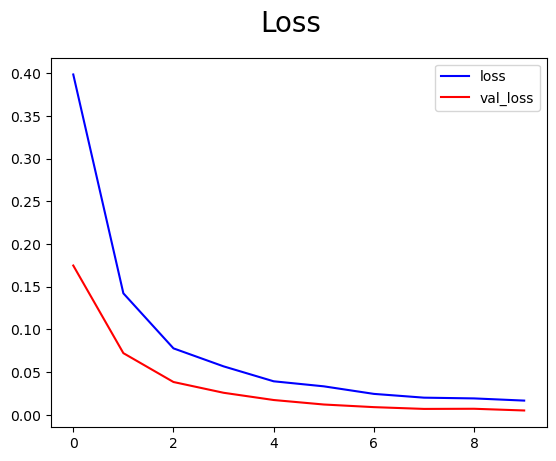

In [19]:
fig = plt.figure()
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

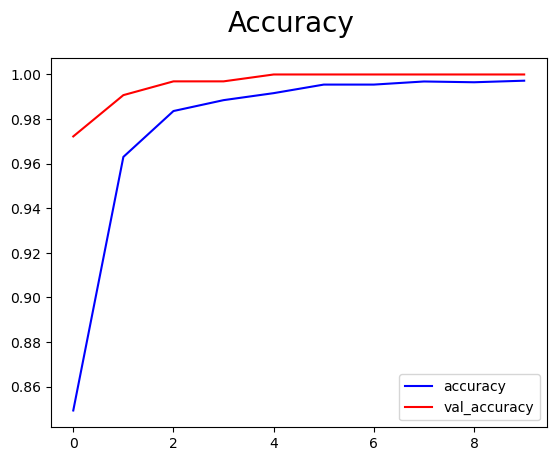

In [20]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()